# TO DO!

- figure out how to deal with the fact that data is not great!

In [94]:
require(ggplot2)
source("00_functions.R")


 loading required packages



## read in data

In [95]:
#trees_df   = read.csv("../Results/trees_family_matrix.csv", row.names=1)
trees_df   = read.csv("../Results/trees_genus_matrix.csv", row.names=1)
#trees_df   = read.csv("../Results/trees_matrix.csv", row.names=1)

trees_df   = read.csv("../Results/trees_genus_matrix.csv", row.names=1)
mammals_df = read.csv("../Results/mammals_matrix.csv", row.names=1)
beetles_df = read.csv("../Results/beetles_matrix.csv", row.names=1)

In [96]:
pca.rslt_trees   = do_pca(trees_df, scale = F, plot = F)
pca.rslt_mammals = do_pca(mammals_df, scale = F, plot = F)
pca.rslt_beetles = do_pca(beetles_df, scale = F, plot = F)

# cat("Explained Varience Trees:")
# pca.rslt_trees@exp.var
# cat("Explained Varience Mammals:")
# pca.rslt_mammals@exp.var
# cat("Explained Varience Beetles:")
# pca.rslt_beetles@exp.var

In [97]:
hvs_rslts_trees   = hvs_rslts(pca.rslt_trees@axis)
hvs_rslts_mammals = hvs_rslts(pca.rslt_mammals@axis)
hvs_rslts_beetles = hvs_rslts(pca.rslt_beetles@axis)

# cat("\n\n")
# cat("Trees: ",   sum(is.na(hvs.rslts_trees@rslts$centroid_PC1))/nrow(hvs.rslts_trees@rslts), "\n")
# cat("Mammals: ", sum(is.na(hvs.rslts_mammals@rslts$centroid_PC1))/nrow(hvs.rslts_mammals@rslts), "\n")
# cat("Beetles: ", sum(is.na(hvs.rslts_beetles@rslts$centroid_PC1))/nrow(hvs.rslts_beetles@rslts))


Building Hypervolume  36  of  36 :  Tower_c44
Comparing Hypervolume  27  of  27 :  Tower_c3-c44

Building Hypervolume  36  of  36 :  E100-2_c2017
Comparing Hypervolume  30  of  30 :  E100-2_c2016-c2017

Building Hypervolume  60  of  60 :  VJR_P3
Comparing Hypervolume  40  of  40 :  VJR_P2-P3


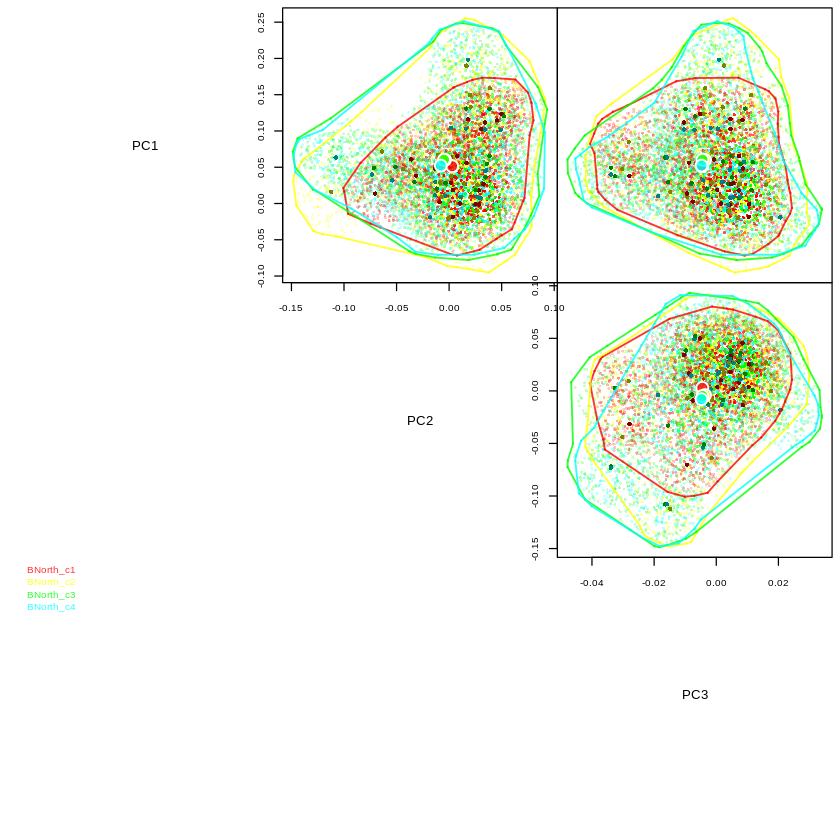

In [122]:
plot_hvs(hvs.rslts_trees, "BNorth")

In [111]:
hvs_rslts_trees@compare

,plot,census_step,centroid_change,overlap,unique_1,unique_2,abs_vol_change,per_vol_change
BNorth_c1-c2,BNorth,c1-c2,0.0129705889,0.5484295,0.03300023,0.44111031,8.171210e-04,0.730215797
BNorth_c2-c3,BNorth,c2-c3,0.0033297028,0.7402499,0.14353061,0.15491369,2.607919e-05,0.013469723
BNorth_c3-c4,BNorth,c3-c4,0.0079062197,0.7649854,0.21130919,0.03780518,-3.538284e-04,-0.180321079
BSouth_c1-c2,BSouth,c1-c2,0.0082981011,0.6668253,0.07517623,0.29495845,3.814743e-04,0.311729451
BSouth_c2-c3,BSouth,c2-c3,0.0063475423,0.6074576,0.19972202,0.28399570,1.889331e-04,0.117699965
BSouth_c3-c4,BSouth,c3-c4,0.0084398855,0.7203046,0.24015873,0.06737047,-3.324008e-04,-0.185269987
Belian_c1-c2,Belian,c1-c2,0.0005266028,0.9122481,0.04742836,0.04434544,-1.734145e-07,-0.003225978
Belian_c2-c3,Belian,c2-c3,0.0010883898,0.7876723,0.19111038,0.03222764,-8.796790e-06,-0.164173666
Belian_c3-c4,Belian,c3-c4,NA,NA,NA,NA,NA,NA
DC1_c1-c2,DC1,c1-c2,0.0008193109,0.7419645,0.05470573,0.22474712,6.341563e-06,0.219336681


In [123]:
a = hvs_rslts_trees@rslts
a = hvs_rslts_mammals@compare

Warning message:
“Removed 6 rows containing missing values (geom_point).”

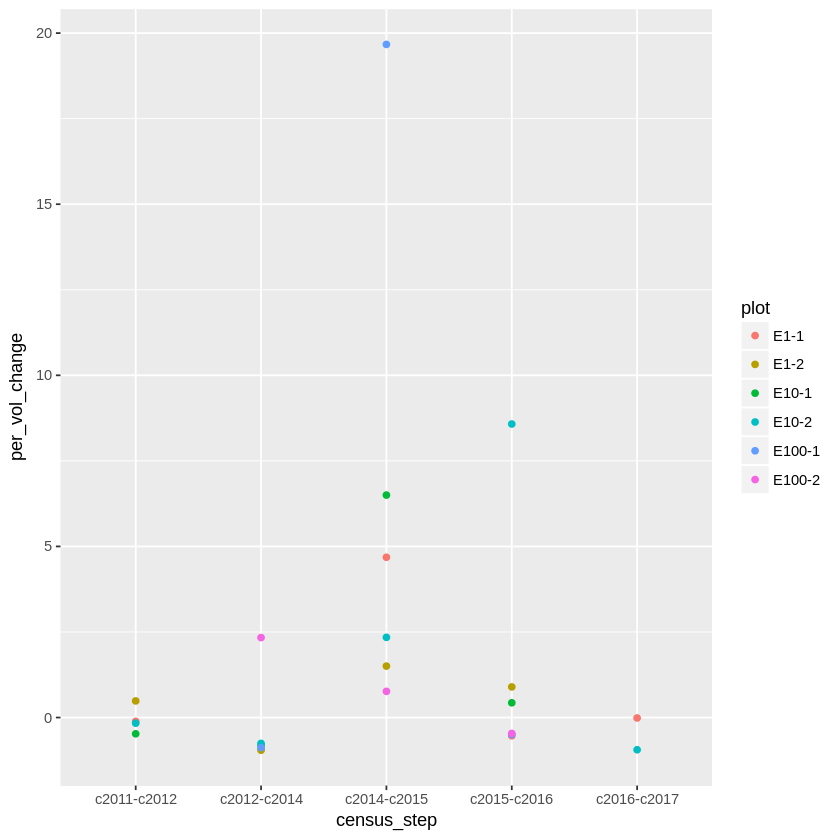

In [127]:
ggplot(data = a, aes(x = census_step, y = per_vol_change, color = plot)) + geom_point()

In [125]:
a


,plot,census_step,centroid_change,overlap,unique_1,unique_2,abs_vol_change,per_vol_change
E1-1_c2011-c2012,E1-1,c2011-c2012,0.24021110,0.12294037,0.79331884,0.76720658,-2.059971e-03,-0.11216923
E1-1_c2012-c2014,E1-1,c2012-c2014,0.16089705,0.01531831,0.98369522,0.79796457,-1.498903e-02,-0.91929743
E1-1_c2014-c2015,E1-1,c2014-c2015,0.10560842,0.06307336,0.60347888,0.93022908,6.162349e-03,4.68318630
E1-1_c2015-c2016,E1-1,c2015-c2016,0.15558293,0.06547378,0.90987165,0.80687530,-3.988235e-03,-0.53331525
E1-1_c2016-c2017,E1-1,c2016-c2017,0.09776797,0.16022169,0.72567559,0.72191580,-4.718542e-05,-0.01352033
E1-2_c2011-c2012,E1-2,c2011-c2012,0.16140790,0.12508383,0.72374637,0.81394576,9.463348e-03,0.48480163
E1-2_c2012-c2014,E1-2,c2012-c2014,0.16088546,0.01883826,0.98068545,0.56691833,-2.769079e-02,-0.95540206
E1-2_c2014-c2015,E1-2,c2014-c2015,0.03789561,0.24636691,0.30757306,0.72335884,1.942750e-03,1.50297871
E1-2_c2015-c2016,E1-2,c2015-c2016,0.09825965,0.11885987,0.69253643,0.83768476,2.893170e-03,0.89423728
E1-2_c2016-c2017,E1-2,c2016-c2017,NA,NA,NA,NA,NA,NA


In [ ]:
attributes <- read.csv("../Results/trees_sorted.csv")
a = as.data.frame(attributes %>% group_by(plot_c) %>% summarise(stem_C = sum(stem_C)))

hvs.rslts@rslts = merge(hvs.rslts@rslts, a, by = "plot_c", all.x = T)